In [1]:
#Importing the required libraries
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

D:\Dani\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
import xgboost
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import class_weight



In [125]:
def last_X_summary_player(df,column,minutes):
    time=str(minutes)+' minutes'
    summs=df.groupby(["match_id","player_id"]).rolling(pd.to_timedelta(time),on='timestamp')[column].sum().reset_index()
    summs.columns=['match_id', 'player_id', 'timestamp', column+'_last_'+str(minutes)+'m']
    df=pd.merge(df,summs,on=["match_id","player_id","timestamp"])
    return df
def last_X_summary_team(df,column,minutes):
    time=str(minutes)+' minutes'
    summs=df.groupby(["match_id"]).rolling(pd.to_timedelta(time),on='timestamp')[column].sum().reset_index()
    summs.columns=['match_id', 'timestamp', column+'_last_'+str(minutes)+'m_team']
    df=pd.merge(df,summs,on=["match_id","timestamp"])
    return df
def training(train, test, model, encoder, scaler=None, imputer='zero'):
    x_train = train[features]
    y_train = train[target]
    x_test = test[features]
    y_test = test[target]

    pipe = Pipeline(steps=[
        ("encoder", encoder),
        ("scaler", scaler),
        ("Model", model)
    ])
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)
    auc = accuracy_score(y_test, preds)
    f1=f1_score(y_test,preds)
    prec=precision_score(y_test,preds)
    rec=recall_score(y_test,preds)
    roc=roc_auc_score(y_test,preds)
    
    metric_dict = {'Auc':auc, 'F1':f1,'Prec':prec,'Recall':rec,'Roc':roc}
    metric_dict=pd.DataFrame([metric_dict])
    
    return(metric_dict)
def evaluate_model(df, model, encoder=None, scaler=None):
    rand_state = 42
    y = df[target]
    X = df[features]
    df = df.fillna(0)
    skf = RepeatedStratifiedKFold(n_splits=4)
    metric_df = pd.DataFrame(columns=['Auc', 'F1','Prec','Recall','Roc'])

    fold_no = 1
    for train_index,test_index in skf.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        metric_dict = training(train, test, model, encoder, scaler)
        metric_df = pd.concat([metric_df, metric_dict], ignore_index=True)
        fold_no += 1

    means = metric_df.mean()
    metric_df = pd.DataFrame(columns = means.index)
    metric_df.loc[len(metric_df)] = means.values
    return(metric_df)

In [4]:
data=pd.read_csv("pl_events.csv",index_col=0)
#de_events=pd.read_csv("de_events.csv")
#df.drop("Unnamed: 0",axis=1)


D:\Dani\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3526: DtypeWarning: Columns (1,2,3,4,5,6,7,9,10,11,14,18,20,21,22,23,24,25,26,27,29,30,31,42,43,44,45,46,48,49,50,54) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313783 entries, 0 to 1313782
Data columns (total 54 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   bad_behaviour_card        193 non-null      object 
 1   ball_receipt_outcome      57945 non-null    object 
 2   pass_outcome              86240 non-null    object 
 3   dribble_outcome           13721 non-null    object 
 4   carry_end_location        276949 non-null   object 
 5   carry_end_location.1      276949 non-null   object 
 6   duel_outcome              15445 non-null    object 
 7   duration                  973459 non-null   float64
 8   foul_committed_card       1069 non-null     object 
 9   foul_committed_penalty    91 non-null       object 
 10  goalkeeper_type           11777 non-null    object 
 11  id                        1313783 non-null  object 
 12  index                     1313783 non-null  int64  
 13  interception_outcome      8

In [6]:
data.type.value_counts()

Pass                 368619
Ball Receipt*        340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Substitution           2109
Half Start             1520
Half End               1520
Injury Stoppage        1032
Starting XI             760
Tactical Shift          625
50/50                   559
Shield                  503
Referee Ball-Drop       272
Bad Behaviour           193
Error                   178
Player Off              145
Player On               144
Offside                 109
Own Goal Against         38
Own Goal For             38
Name: type, dtype: int64

In [41]:
df=data.copy()

In [42]:
df['duration']=np.where(df['duration']<0,0,df['duration'])

In [43]:
#df["related_events_0"]=df["related_events"].apply(lambda x: ast.literal_eval(x)[0]  if pd.notnull(x) and x.strip().startswith('[') else [])

In [44]:
df=df[df["timestamp"]!="00:00:00.000"]

In [45]:
df["timestamp"]=pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
df["timestamp"]=np.where(df["period"]==1,df["timestamp"],df["timestamp"]+pd.to_timedelta('45 minutes'))
df["timestamp"]=df["timestamp"].dt.strftime('%H:%M:%S.%f')
df["timestamp"]=pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

In [46]:
matches=data[data["type"]=="Starting XI"][["match_id","team"]]
matches["team_against"]=matches.groupby("match_id")["team"].shift(-1)
matches.columns=["match_id","home_team","away_team"]
matches.dropna(inplace=True)
df=df.merge(matches,on="match_id",how="left")
df["home_or_away_event"]=np.where(df["team"]==df["home_team"],1,-1)

In [47]:
df["pass_success"]=np.where((df["type"]=='Pass')&(df["pass_outcome"].isna()),1,np.where(df["type"]=='Pass',0,np.NaN))

In [48]:
df["pass_success_home"]=np.where((df["pass_success"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["pass_success_away"]=np.where((df["pass_success"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [49]:
df["rand"]=np.random.randint(0,9000000,df.shape[0])

In [50]:
df["rand"]=pd.to_timedelta(df["rand"],unit='ns')

In [51]:
df["timestamp"]=df["timestamp"]+df["rand"]+df["rand"].shift(1)+df["rand"].shift(-2)

In [52]:
df.drop("rand",axis=1,inplace=True)
df=df[df["timestamp"].isna()==False]

In [53]:
df.sort_values(["match_id","player_id","timestamp"],inplace=True)

In [54]:
df["pass_miss"]=np.where(df["pass_success"]==0,1,np.NaN)
df["pass_miss_home"]=np.where((df["pass_miss"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["pass_miss_away"]=np.where((df["pass_miss"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [55]:
df["duel_success"]=np.where((df["duel_outcome"]=="Won")|(df["duel_outcome"]=="Success In Play"),1,np.where(df["type"]=="Duel",0,np.NaN))
df["duel_fail"]=np.where(df["duel_success"]==0,1,np.where(df["type"]=="Duel",0,np.NaN))
df["duel_success_home"]=np.where((df["duel_success"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["duel_success_away"]=np.where((df["duel_success"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [56]:
df.loc[df["dribble_outcome"]=="Complete","dribble_success"]=1
df.loc[df["dribble_outcome"]=="Incomplete","dribble_success"]=0
df.loc[df["dribble_outcome"]=="Complete","dribble_fail"]=0
df.loc[df["dribble_outcome"]=="Incomplete","dribble_fail"]=1
df["dribble_success_home"]=np.where((df["dribble_success"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["dribble_success_away"]=np.where((df["dribble_success"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [57]:
df["shot_goal"]=np.where((df["shot_outcome"]=='Goal'),1,np.where(df["type"]=='Shot',0,np.NaN))
df["shot_big_chances_missed"]=np.where((df["shot_goal"]==0)&(df["shot_statsbomb_xg"]>0.3),1,np.NaN)

In [58]:
df["dribbled_past"]=np.where(df["type"]=='Dribbled Past',1,np.NaN)

In [59]:
df[['location_x', 'location_y']] = df['location'].str.strip('[]').str.split(',', expand=True)
df["location_x"]=pd.to_numeric(df["location_x"])
df["location_y"]=pd.to_numeric(df["location_y"])

In [60]:
df["opp_half_pass_comp"]=np.where((df["pass_success"]==1)&(df["location_x"]>=60),1,np.NaN)
df["final_third_pass_comp"]=np.where((df["pass_success"]==1)&(df["location_x"]>80),1,np.NaN)
df["own_half_pass_miss"]=np.where((df["pass_miss"]==1)&(df["location_x"]<=60),1,np.NaN)

In [61]:
df["opp_half_pass_comp_home"]=np.where((df["opp_half_pass_comp"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["opp_half_pass_comp_away"]=np.where((df["opp_half_pass_comp"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [62]:
df["final_third_pass_home"]=np.where((df["final_third_pass_comp"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["final_third_pass_away"]=np.where((df["final_third_pass_comp"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [63]:
df["own_half_pass_miss_home"]=np.where((df["own_half_pass_miss"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["own_half_pass_miss_away"]=np.where((df["own_half_pass_miss"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [64]:
df["shot_big_chances_missed_home"]=np.where((df["shot_big_chances_missed"]==1)&(df["home_or_away_event"]==1),1,np.NaN)
df["shot_big_chances_missed_away"]=np.where((df["shot_big_chances_missed"]==1)&(df["home_or_away_event"]==-1),1,np.NaN)

In [65]:
df["home_goal"]=np.where(((df["shot_goal"]==1)&(df["team"]==df["home_team"]))|((df["type"]=="Own Goal For")&(df["team"]==df["home_team"])),1,np.NaN)
df["away_goal"]=np.where(((df["shot_goal"]==1)&(df["team"]==df["away_team"]))|((df["type"]=="Own Goal For")&(df["team"]==df["away_team"])),1,np.NaN)

In [66]:
df.sort_values(["match_id","timestamp"],inplace=True)
df["home_goals"]=df.groupby("match_id")["home_goal"].cumsum()
df["home_goals"]=df.groupby("match_id")["home_goals"].ffill().fillna(0)
df["away_goals"]=df.groupby("match_id")["away_goal"].cumsum()
df["away_goals"]=df.groupby("match_id")["away_goals"].ffill().fillna(0)

In [67]:
home_summs=df.sort_values(["match_id","timestamp"],ascending=False).groupby(["match_id"]).rolling(pd.to_timedelta("10 minutes"),on='timestamp')["home_goal"].sum().reset_index()
home_summs.columns=['match_id','timestamp', 'home_goal_in_next_10']
df=pd.merge(df,home_summs,on=["match_id","timestamp"])

away_summs=df.sort_values(["match_id","timestamp"],ascending=False).groupby(["match_id"]).rolling(pd.to_timedelta("10 minutes"),on='timestamp')["away_goal"].sum().reset_index()
away_summs.columns=['match_id','timestamp', 'away_goal_in_next_10']
df=pd.merge(df,away_summs,on=["match_id","timestamp"])

In [68]:
df["match_state"]=(df["home_goals"]-df["away_goals"])*df["home_or_away_event"]

In [69]:
df["scoring_in_10"]=np.where(((df["home_or_away_event"]==1)&(df["home_goal_in_next_10"]>0))|((df["home_or_away_event"]==-1)&(df["away_goal_in_next_10"]>0)),1,0)
df["conceding_in_10"]=np.where(((df["home_or_away_event"]==1)&(df["away_goal_in_next_10"]>0))|((df["home_or_away_event"]==-1)&(df["home_goal_in_next_10"]>0)),1,0)

<h1>MODELLING</h1>

In [72]:
player_vars=["pass_success","pass_miss","duel_success","duel_fail","dribble_success","shot_goal","shot_big_chances_missed","dribbled_past","own_half_pass_miss","final_third_pass_comp"]
home_vars=['pass_success_home',"pass_miss_home","duel_success_home",'dribble_success_home',"shot_big_chances_missed_home","final_third_pass_home","own_half_pass_miss_home",'opp_half_pass_comp_home']
away_vars=['pass_success_away',"pass_miss_away","duel_success_away",'dribble_success_away',"shot_big_chances_missed_away","final_third_pass_away","own_half_pass_miss_away",'opp_half_pass_comp_away']
team_vars=home_vars+away_vars

<h2><b>Scoring model for xG</b></h2>

In [73]:
df_xg=df.copy()
scoring_model_cols=["shot_statsbomb_xg","match_state","home_or_away_event","shot_goal"]
minutes=15
for column in player_vars:
    df_xg=last_X_summary_player(df_xg,column,minutes)
    scoring_model_cols.append(column+'_last_'+str(minutes)+'m')

for column in team_vars:
    df_xg=last_X_summary_team(df_xg,column,minutes)


In [79]:
df_xg["pass_success_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["pass_success_home_last_15m_team"],df_xg["pass_success_away_last_15m_team"])
df_xg["pass_success_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["pass_success_home_last_15m_team"],df_xg["pass_success_away_last_15m_team"])

df_xg["pass_miss_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["pass_miss_home_last_15m_team"],df_xg["pass_miss_away_last_15m_team"])
df_xg["pass_miss_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["pass_miss_home_last_15m_team"],df_xg["pass_miss_away_last_15m_team"])

df_xg["dribble_success_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["dribble_success_home_last_15m_team"],df_xg["dribble_success_away_last_15m_team"])
df_xg["dribble_sucess_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["dribble_success_home_last_15m_team"],df_xg["dribble_success_away_last_15m_team"])

df_xg["duel_success_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["duel_success_home_last_15m_team"],df_xg["duel_success_away_last_15m_team"])
df_xg["duel_success_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["duel_success_home_last_15m_team"],df_xg["duel_success_away_last_15m_team"])

df_xg["shot_big_chances_missed_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["shot_big_chances_missed_home_last_15m_team"],df_xg["shot_big_chances_missed_away_last_15m_team"])
df_xg["shot_big_chances_missed_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["shot_big_chances_missed_home_last_15m_team"],df_xg["shot_big_chances_missed_away_last_15m_team"])

df_xg["final_third_pass_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["final_third_pass_home_last_15m_team"],df_xg["final_third_pass_away_last_15m_team"])
df_xg["final_third_pass_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["final_third_pass_home_last_15m_team"],df_xg["final_third_pass_away_last_15m_team"])

df_xg["own_half_pass_miss_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["own_half_pass_miss_home_last_15m_team"],df_xg["own_half_pass_miss_away_last_15m_team"])
df_xg["own_half_pass_miss_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["own_half_pass_miss_home_last_15m_team"],df_xg["own_half_pass_miss_away_last_15m_team"])

df_xg["opp_half_pass_comp_own_last_15m"]=np.where(df_xg["home_or_away_event"]==1,df_xg["opp_half_pass_comp_home_last_15m_team"],df_xg["opp_half_pass_comp_away_last_15m_team"])
df_xg["opp_half_pass_comp_opp_last_15m"]=np.where(df_xg["home_or_away_event"]==-1,df_xg["opp_half_pass_comp_home_last_15m_team"],df_xg["opp_half_pass_comp_away_last_15m_team"])

##field tilt helye

In [80]:
team_cols=["pass_success_own_last_15m","pass_success_opp_last_15m","pass_miss_own_last_15m","pass_miss_opp_last_15m","dribble_success_own_last_15m","dribble_sucess_opp_last_15m","duel_success_own_last_15m","duel_success_opp_last_15m","shot_big_chances_missed_own_last_15m","shot_big_chances_missed_opp_last_15m","final_third_pass_own_last_15m","final_third_pass_opp_last_15m","own_half_pass_miss_own_last_15m","own_half_pass_miss_opp_last_15m","opp_half_pass_comp_own_last_15m","opp_half_pass_comp_opp_last_15m"]

In [81]:
xg_model_cols=scoring_model_cols+team_cols

In [82]:
model_xg_15_player=df_xg[df_xg["type"]=="Shot"][scoring_model_cols].drop(["shot_goal_last_15m"],axis=1)

In [83]:
model_xg_15_all=df_xg[df_xg["type"]=="Shot"][xg_model_cols].drop(["shot_goal_last_15m"],axis=1)

In [85]:
model_xg_15_all.tail()

,shot_statsbomb_xg,match_state,home_or_away_event,shot_goal,pass_success_last_15m,pass_miss_last_15m,duel_success_last_15m,duel_fail_last_15m,dribble_success_last_15m,shot_big_chances_missed_last_15m,dribbled_past_last_15m,own_half_pass_miss_last_15m,final_third_pass_comp_last_15m,pass_success_own_last_15m,pass_success_opp_last_15m,pass_miss_own_last_15m,pass_miss_opp_last_15m,dribble_success_own_last_15m,dribble_sucess_opp_last_15m,duel_success_own_last_15m,duel_success_opp_last_15m,shot_big_chances_missed_own_last_15m,shot_big_chances_missed_opp_last_15m,final_third_pass_own_last_15m,final_third_pass_opp_last_15m,own_half_pass_miss_own_last_15m,own_half_pass_miss_opp_last_15m,opp_half_pass_comp_own_last_15m,opp_half_pass_comp_opp_last_15m
1308487,0.058,-0.000,-1,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.000,51.000,20.000,20.000,1.000,1.000,1.000,1.000,NaN,NaN,7.000,14.000,9.000,7.000,13.000,22.000
1308491,0.097,1.000,-1,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.000,51.000,20.000,20.000,1.000,1.000,1.000,1.000,NaN,NaN,7.000,14.000,9.000,7.000,13.000,22.000
1308544,0.027,-1.000,1,0.000,3.000,2.000,NaN,NaN,NaN,NaN,NaN,1.000,3.000,51.000,24.000,21.000,17.000,1.000,1.000,2.000,1.000,NaN,NaN,13.000,7.000,9.000,8.000,25.000,12.000
1308629,0.040,-1.000,1,0.000,4.000,3.000,NaN,NaN,NaN,NaN,NaN,2.000,3.000,57.000,20.000,17.000,14.000,1.000,1.000,1.000,2.000,NaN,NaN,15.000,7.000,7.000,6.000,29.000,11.000
1308764,0.006,-1.000,1,0.000,8.000,3.000,NaN,NaN,NaN,NaN,NaN,2.000,2.000,62.000,13.000,22.000,9.000,3.000,1.000,2.000,2.000,NaN,NaN,14.000,4.000,6.000,5.000,28.000,7.000


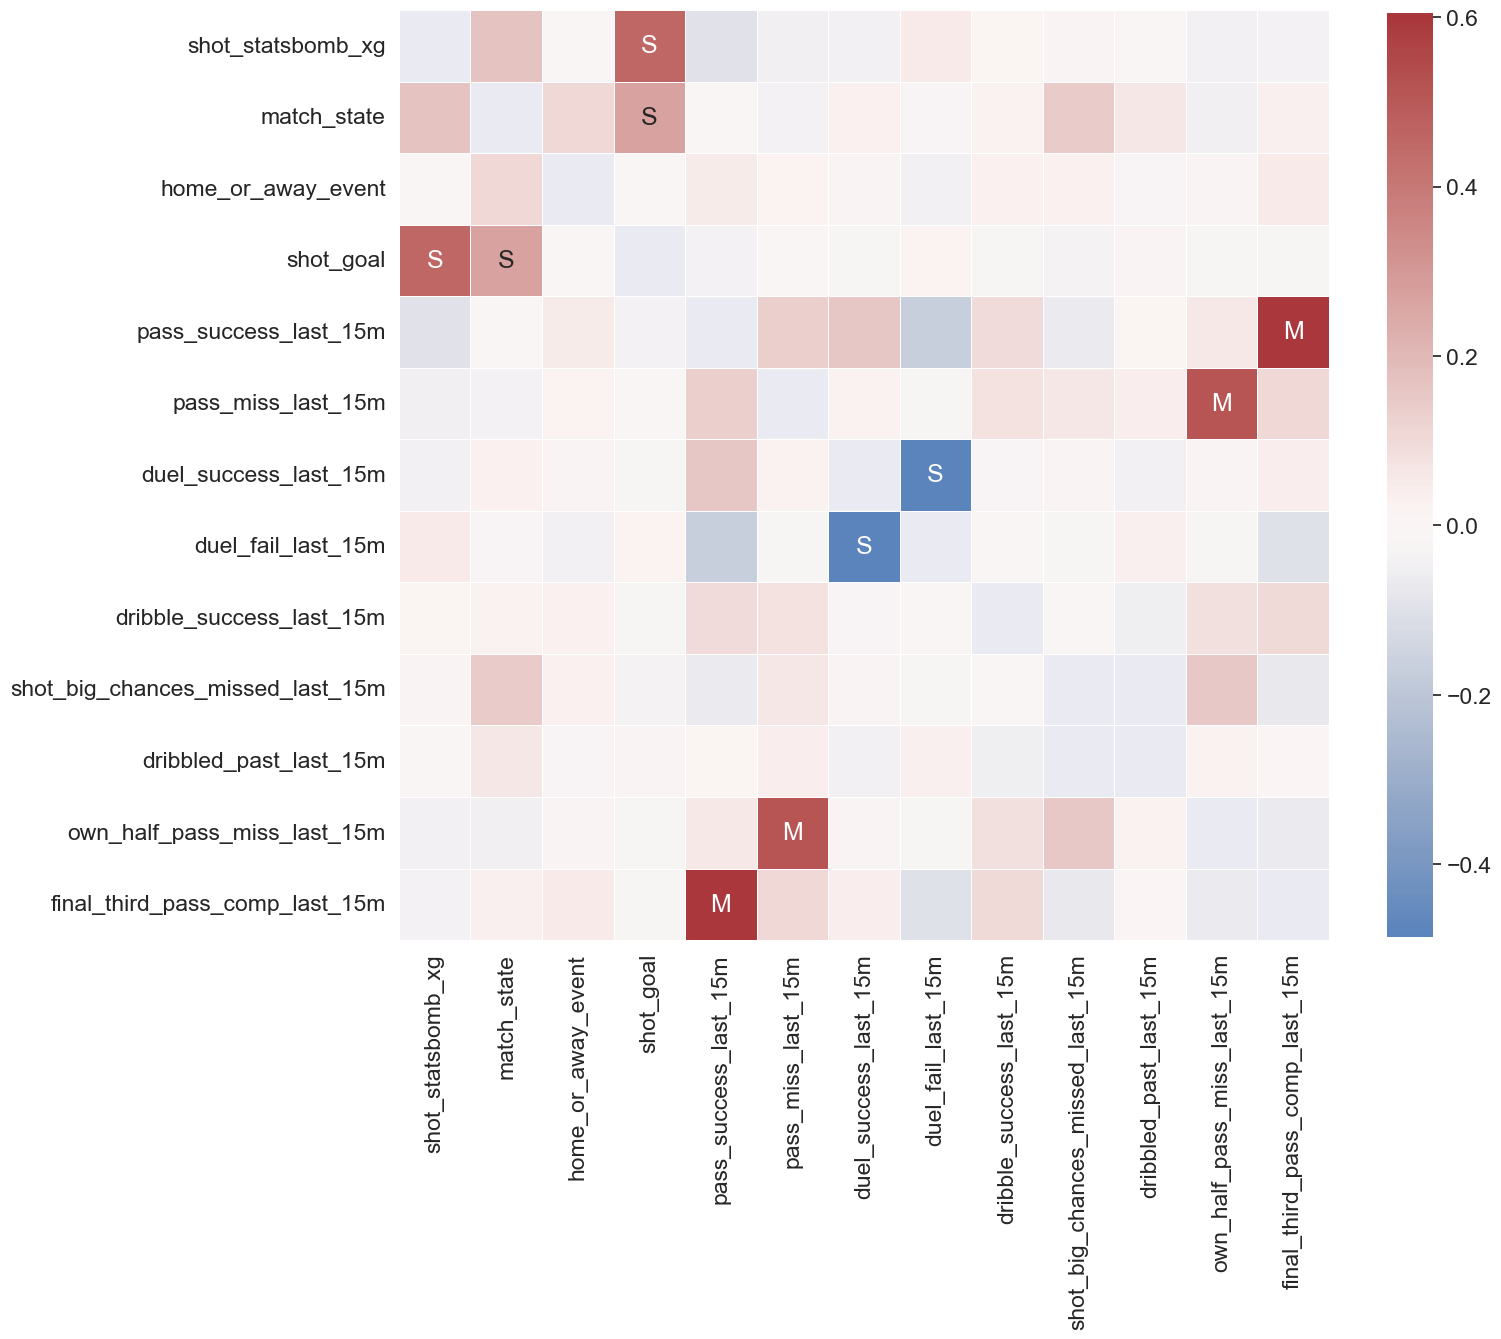

In [86]:
#Feature correlation

# Computes feature correlation
df_corr = model_xg_15_player.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "S", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8},);

<h2>Own/Opp team cols

In [87]:
target="shot_goal"
features=model_xg_15_all.drop("shot_goal",axis=1).columns

In [88]:
model=RandomForestClassifier()
evaluate_model(model_xg_15_all,model)##all

,Auc,F1,Prec,Recall,Roc
0,0.936,0.545,0.938,0.385,0.691


In [89]:
model=xgboost.XGBRFClassifier()
evaluate_model(model_xg_15_all,model)##all

,Auc,F1,Prec,Recall,Roc
0,0.935,0.534,0.941,0.373,0.685


Compared to home/away cols: Better, small margin

In [90]:
logistic_classifier = LogisticRegression(max_iter=3550,C=1.3)
tree_classifier = RandomForestClassifier()
xgb= xgboost.XGBRFClassifier()

In [91]:
model=VotingClassifier(estimators=[
    ('logistic', logistic_classifier),
    ('tree', tree_classifier),
    ('xg', xgb)
], voting='soft')

evaluate_model(model_xg_15_all,model)##all

,Auc,F1,Prec,Recall,Roc
0,0.935,0.540,0.929,0.382,0.689


In [93]:
model=VotingClassifier(estimators=[
    ('logistic', logistic_classifier),
    ('tree', tree_classifier),
    ('xg', xgb)
], voting='soft')
bagging_classifier = BaggingClassifier(base_estimator=model, n_estimators=15, random_state=42)
evaluate_model(model_xg_15_all,bagging_classifier)##all

,Auc,F1,Prec,Recall,Roc
0,0.934,0.524,0.945,0.363,0.681


<h2>Home/away team cols (old version)

In [50]:
target="shot_goal"
features=model_xg_30.drop("shot_goal",axis=1).columns

NameError: name 'model_xg_30' is not defined

In [53]:
model=RandomForestClassifier()
evaluate_model(model_xg_30,model)##all

,Auc,F1,Prec,Recall,Roc
0,0.934,0.536,0.898,0.383,0.689


In [54]:
model=LogisticRegression()
evaluate_model(model_xg_30,model)##all

D:\Dani\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Dani\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

,Auc,F1,Prec,Recall,Roc
0,0.916,0.354,0.774,0.231,0.612


In [55]:
model=xgboost.XGBRFClassifier()
evaluate_model(model_xg_30,model)##all

,Auc,F1,Prec,Recall,Roc
0,0.934,0.530,0.923,0.374,0.685


In [56]:
target="shot_goal"
features=["shot_statsbomb_xg","match_state"]
features_2=model_xg_30.drop("shot_goal",axis=1).columns

In [57]:
model=RandomForestClassifier()
evaluate_model(model_xg_30,model)##Only

,Auc,F1,Prec,Recall,Roc
0,0.875,0.362,0.370,0.355,0.644


In [58]:
model=LogisticRegression()
evaluate_model(model_xg_30,model)##onlyxg

,Auc,F1,Prec,Recall,Roc
0,0.915,0.377,0.705,0.258,0.623


In [59]:
model=xgboost.XGBRFClassifier()
evaluate_model(model_xg_30,model)##onlyxg

,Auc,F1,Prec,Recall,Roc
0,0.915,0.397,0.692,0.280,0.633


<h2>Scoring/conceding in the next 10 mins</h2>

In [94]:
df_conc=df.copy()
conc_model_cols=["conceding_in_10","match_state","home_or_away_event"]
minutes=5
minutes_2=20
for column in player_vars:
    df_conc=last_X_summary_player(df_conc,column,minutes)
    df_conc=last_X_summary_player(df_conc,column,minutes_2)
    col_name_1=column+'_last_'+str(minutes)+'m'
    col_name_2=column+'_last_'+str(minutes_2)+'m'
    df_conc[col_name_2]=df_conc[col_name_2]-df_conc[col_name_1]
    conc_model_cols.extend([col_name_1,col_name_2])

for column in team_vars:
    df_conc=last_X_summary_team(df_conc,column,minutes)
    df_conc=last_X_summary_team(df_conc,column,minutes_2)
    col_name_1=column+'_last_'+str(minutes)+'m_team'
    col_name_2=column+'_last_'+str(minutes_2)+'m_team'
    df_conc[col_name_2]=df_conc[col_name_2]-df_conc[col_name_1]


In [97]:
df_conc["pass_success_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["pass_success_home_last_20m_team"],df_conc["pass_success_away_last_20m_team"])
df_conc["pass_success_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["pass_success_home_last_20m_team"],df_conc["pass_success_away_last_20m_team"])

df_conc["pass_miss_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["pass_miss_home_last_20m_team"],df_conc["pass_miss_away_last_20m_team"])
df_conc["pass_miss_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["pass_miss_home_last_20m_team"],df_conc["pass_miss_away_last_20m_team"])

df_conc["dribble_success_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["dribble_success_home_last_20m_team"],df_conc["dribble_success_away_last_20m_team"])
df_conc["dribble_sucess_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["dribble_success_home_last_20m_team"],df_conc["dribble_success_away_last_20m_team"])

df_conc["duel_success_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["duel_success_home_last_20m_team"],df_conc["duel_success_away_last_20m_team"])
df_conc["duel_success_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["duel_success_home_last_20m_team"],df_conc["duel_success_away_last_20m_team"])

df_conc["shot_big_chances_missed_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["shot_big_chances_missed_home_last_20m_team"],df_conc["shot_big_chances_missed_away_last_20m_team"])
df_conc["shot_big_chances_missed_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["shot_big_chances_missed_home_last_20m_team"],df_conc["shot_big_chances_missed_away_last_20m_team"])

df_conc["final_third_pass_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["final_third_pass_home_last_20m_team"],df_conc["final_third_pass_away_last_20m_team"])
df_conc["final_third_pass_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["final_third_pass_home_last_20m_team"],df_conc["final_third_pass_away_last_20m_team"])

df_conc["own_half_pass_miss_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["own_half_pass_miss_home_last_20m_team"],df_conc["own_half_pass_miss_away_last_20m_team"])
df_conc["own_half_pass_miss_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["own_half_pass_miss_home_last_20m_team"],df_conc["own_half_pass_miss_away_last_20m_team"])

df_conc["opp_half_pass_comp_own_last_20m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["opp_half_pass_comp_home_last_20m_team"],df_conc["opp_half_pass_comp_away_last_20m_team"])
df_conc["opp_half_pass_comp_opp_last_20m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["opp_half_pass_comp_home_last_20m_team"],df_conc["opp_half_pass_comp_away_last_20m_team"])

##field tilt helye

df_conc["pass_success_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["pass_success_home_last_5m_team"],df_conc["pass_success_away_last_5m_team"])
df_conc["pass_success_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["pass_success_home_last_5m_team"],df_conc["pass_success_away_last_5m_team"])

df_conc["pass_miss_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["pass_miss_home_last_5m_team"],df_conc["pass_miss_away_last_5m_team"])
df_conc["pass_miss_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["pass_miss_home_last_5m_team"],df_conc["pass_miss_away_last_5m_team"])

df_conc["dribble_success_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["dribble_success_home_last_5m_team"],df_conc["dribble_success_away_last_5m_team"])
df_conc["dribble_sucess_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["dribble_success_home_last_5m_team"],df_conc["dribble_success_away_last_5m_team"])

df_conc["duel_success_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["duel_success_home_last_5m_team"],df_conc["duel_success_away_last_5m_team"])
df_conc["duel_success_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["duel_success_home_last_5m_team"],df_conc["duel_success_away_last_5m_team"])

df_conc["shot_big_chances_missed_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["shot_big_chances_missed_home_last_5m_team"],df_conc["shot_big_chances_missed_away_last_5m_team"])
df_conc["shot_big_chances_missed_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["shot_big_chances_missed_home_last_5m_team"],df_conc["shot_big_chances_missed_away_last_5m_team"])

df_conc["final_third_pass_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["final_third_pass_home_last_5m_team"],df_conc["final_third_pass_away_last_5m_team"])
df_conc["final_third_pass_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["final_third_pass_home_last_5m_team"],df_conc["final_third_pass_away_last_5m_team"])

df_conc["own_half_pass_miss_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["own_half_pass_miss_home_last_5m_team"],df_conc["own_half_pass_miss_away_last_5m_team"])
df_conc["own_half_pass_miss_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["own_half_pass_miss_home_last_5m_team"],df_conc["own_half_pass_miss_away_last_5m_team"])

df_conc["opp_half_pass_comp_own_last_5m"]=np.where(df_conc["home_or_away_event"]==1,df_conc["opp_half_pass_comp_home_last_5m_team"],df_conc["opp_half_pass_comp_away_last_5m_team"])
df_conc["opp_half_pass_comp_opp_last_5m"]=np.where(df_conc["home_or_away_event"]==-1,df_conc["opp_half_pass_comp_home_last_5m_team"],df_conc["opp_half_pass_comp_away_last_5m_team"])

##field tilt helye

df_conc["field_tilt_20m"]=(df_conc["opp_half_pass_comp_own_last_5m"]+df_conc["opp_half_pass_comp_own_last_20m"])/(df_conc["opp_half_pass_comp_own_last_5m"]+df_conc["opp_half_pass_comp_own_last_20m"]+df_conc["opp_half_pass_comp_opp_last_5m"]+df_conc["opp_half_pass_comp_opp_last_20m"])

In [98]:
conc_team_cols=["pass_success_own_last_20m","pass_success_opp_last_20m","pass_miss_own_last_20m","pass_miss_opp_last_20m","dribble_success_own_last_20m","dribble_sucess_opp_last_20m","duel_success_own_last_20m","duel_success_opp_last_20m","shot_big_chances_missed_own_last_20m","shot_big_chances_missed_opp_last_20m","final_third_pass_own_last_20m","final_third_pass_opp_last_20m","own_half_pass_miss_own_last_20m","own_half_pass_miss_opp_last_20m","opp_half_pass_comp_own_last_20m","opp_half_pass_comp_opp_last_20m","pass_success_own_last_5m","pass_success_opp_last_5m","pass_miss_own_last_5m","pass_miss_opp_last_5m","dribble_success_own_last_5m","dribble_sucess_opp_last_5m","duel_success_own_last_5m","duel_success_opp_last_5m","shot_big_chances_missed_own_last_5m","shot_big_chances_missed_opp_last_5m","final_third_pass_own_last_5m","final_third_pass_opp_last_5m","own_half_pass_miss_own_last_5m","own_half_pass_miss_opp_last_5m","opp_half_pass_comp_own_last_5m","opp_half_pass_comp_opp_last_5m","field_tilt_20m"]

In [99]:
conc_model_cols=conc_model_cols+conc_team_cols

<h3>Conceding in 10

In [100]:
model_conceding=df_conc[df_conc["minute"]>=5][conc_model_cols].fillna(0)

In [101]:
model_conceding.tail()

,conceding_in_10,match_state,home_or_away_event,pass_success_last_5m,pass_success_last_20m,pass_miss_last_5m,pass_miss_last_20m,duel_success_last_5m,duel_success_last_20m,duel_fail_last_5m,duel_fail_last_20m,dribble_success_last_5m,dribble_success_last_20m,shot_goal_last_5m,shot_goal_last_20m,shot_big_chances_missed_last_5m,shot_big_chances_missed_last_20m,dribbled_past_last_5m,dribbled_past_last_20m,own_half_pass_miss_last_5m,own_half_pass_miss_last_20m,final_third_pass_comp_last_5m,final_third_pass_comp_last_20m,pass_success_own_last_20m,pass_success_opp_last_20m,pass_miss_own_last_20m,pass_miss_opp_last_20m,dribble_success_own_last_20m,dribble_sucess_opp_last_20m,duel_success_own_last_20m,duel_success_opp_last_20m,shot_big_chances_missed_own_last_20m,shot_big_chances_missed_opp_last_20m,final_third_pass_own_last_20m,final_third_pass_opp_last_20m,own_half_pass_miss_own_last_20m,own_half_pass_miss_opp_last_20m,opp_half_pass_comp_own_last_20m,opp_half_pass_comp_opp_last_20m,pass_success_own_last_5m,pass_success_opp_last_5m,pass_miss_own_last_5m,pass_miss_opp_last_5m,dribble_success_own_last_5m,dribble_sucess_opp_last_5m,duel_success_own_last_5m,duel_success_opp_last_5m,shot_big_chances_missed_own_last_5m,shot_big_chances_missed_opp_last_5m,final_third_pass_own_last_5m,final_third_pass_opp_last_5m,own_half_pass_miss_own_last_5m,own_half_pass_miss_opp_last_5m,opp_half_pass_comp_own_last_5m,opp_half_pass_comp_opp_last_5m,field_tilt_20m
1308857,0,-1.000,1,3.000,7.000,4.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,2.000,1.000,63.000,13.000,20.000,9.000,0.000,0.000,2.000,2.000,0.000,0.000,13.000,4.000,6.000,5.000,27.000,7.000,16.000,3.000,10.000,7.000,0.000,0.000,1.000,1.000,0.000,0.000,9.000,1.000,5.000,4.000,13.000,1.000,0.833
1308858,0,-1.000,1,2.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,64.000,13.000,20.000,9.000,0.000,0.000,2.000,2.000,0.000,0.000,13.000,4.000,6.000,5.000,28.000,7.000,15.000,3.000,10.000,7.000,0.000,0.000,1.000,1.000,0.000,0.000,9.000,1.000,5.000,4.000,12.000,1.000,0.833
1308859,0,-1.000,1,2.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,64.000,13.000,20.000,9.000,0.000,0.000,2.000,2.000,0.000,0.000,13.000,4.000,6.000,5.000,28.000,7.000,15.000,3.000,10.000,7.000,0.000,0.000,1.000,1.000,0.000,0.000,9.000,1.000,5.000,4.000,12.000,1.000,0.833
1308860,0,-1.000,1,2.000,14.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,64.000,13.000,20.000,9.000,0.000,0.000,2.000,2.000,0.000,0.000,13.000,4.000,6.000,5.000,28.000,7.000,15.000,3.000,11.000,7.000,0.000,0.000,1.000,1.000,0.000,0.000,9.000,1.000,5.000,4.000,12.000,1.000,0.833
1308861,0,1.000,-1,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,13.000,64.000,9.000,20.000,0.000,0.000,2.000,2.000,0.000,0.000,4.000,13.000,5.000,6.000,7.000,28.000,3.000,15.000,7.000,11.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,9.000,4.000,5.000,1.000,12.000,0.167


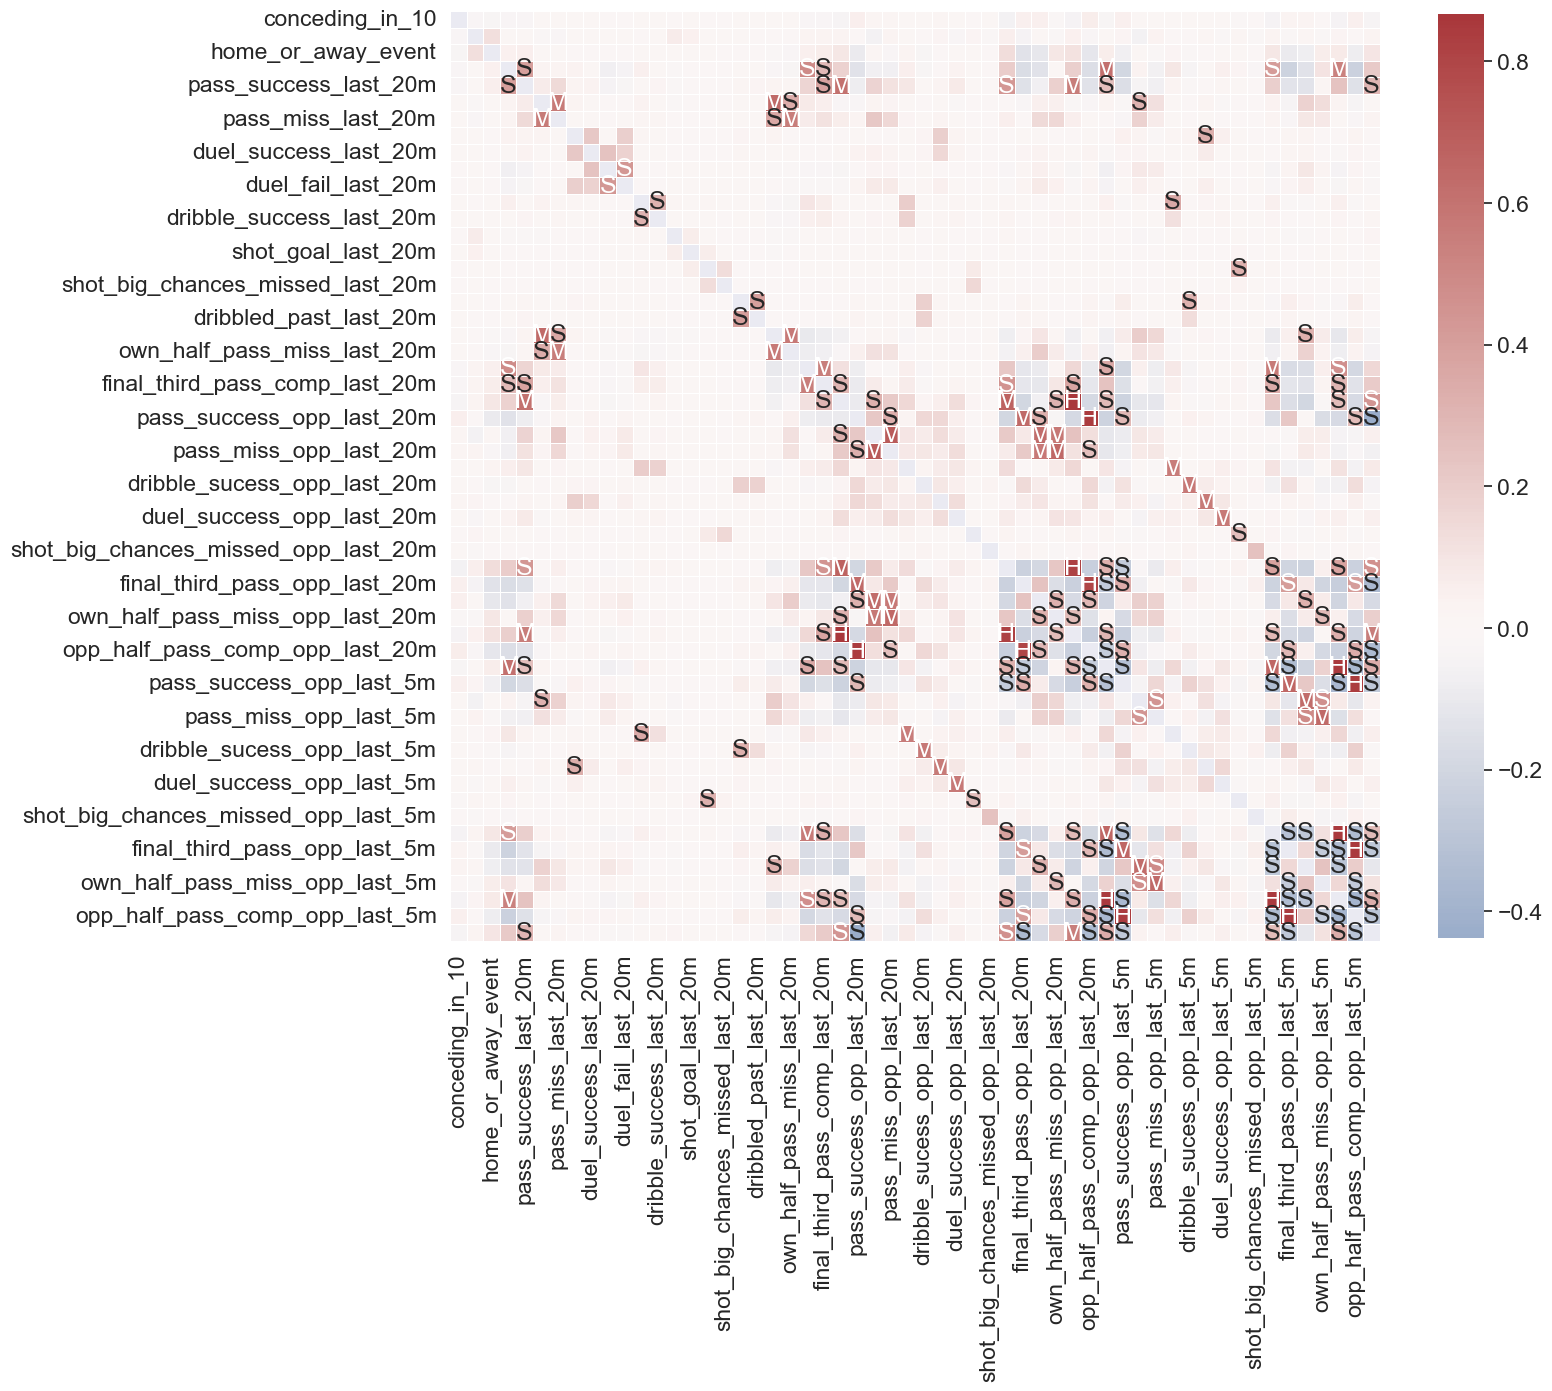

In [102]:
#Feature correlation

# Computes feature correlation
df_corr = model_conceding.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "S", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8},);

In [103]:
target="conceding_in_10"
features=model_conceding.drop([target],axis=1).columns

In [104]:
 X_train, X_test, y_train, y_test = train_test_split(model_conceding[features], model_conceding[target], test_size=0.33, random_state=42)

In [105]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [106]:
y_train.value_counts()

0    718057
1    104219
Name: conceding_in_10, dtype: int64

<h2>Own/Opp team vars

In [126]:
model=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
evaluate_model(model_conceding,model)

KeyError: 'scoring_in_10'

In [108]:
model=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
evaluate_model(model_conceding,model)

,Auc,F1,Prec,Recall,Roc
0,0.555,0.232,0.149,0.531,0.545


In [109]:
logistic_classifier = LogisticRegression(max_iter=3550,C=1.3)
tree_classifier = RandomForestClassifier()
xg= xgboost.XGBRFClassifier()

In [110]:
model=VotingClassifier(estimators=[
    ('logistic', logistic_classifier),
    ('tree', tree_classifier),
    ('xg', xg)
], voting='soft')
evaluate_model(model_conceding,model)

,Auc,F1,Prec,Recall,Roc
0,0.873,0.000,1.000,0.000,0.500


<h2>Home/away (old version)

In [68]:
model=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
evaluate_model(model_conceding,model)

,Auc,F1,Prec,Recall,Roc
0,0.873,0.000,0.363,0.000,0.500


In [69]:
model=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
evaluate_model(model_conceding,model)

,Auc,F1,Prec,Recall,Roc
0,0.580,0.216,0.142,0.458,0.528


<h3>Scoring in 10

In [111]:
scoring_model_cols=conc_model_cols

In [112]:
scoring_model_cols.remove("conceding_in_10")

In [113]:
scoring_model_cols.append("scoring_in_10")

In [114]:
model_scoring=df_conc[df_conc["minute"]>=5][scoring_model_cols].fillna(0)

In [115]:
model_scoring.head()

,match_state,home_or_away_event,pass_success_last_5m,pass_success_last_20m,pass_miss_last_5m,pass_miss_last_20m,duel_success_last_5m,duel_success_last_20m,duel_fail_last_5m,duel_fail_last_20m,dribble_success_last_5m,dribble_success_last_20m,shot_goal_last_5m,shot_goal_last_20m,shot_big_chances_missed_last_5m,shot_big_chances_missed_last_20m,dribbled_past_last_5m,dribbled_past_last_20m,own_half_pass_miss_last_5m,own_half_pass_miss_last_20m,final_third_pass_comp_last_5m,final_third_pass_comp_last_20m,pass_success_own_last_20m,pass_success_opp_last_20m,pass_miss_own_last_20m,pass_miss_opp_last_20m,dribble_success_own_last_20m,dribble_sucess_opp_last_20m,duel_success_own_last_20m,duel_success_opp_last_20m,shot_big_chances_missed_own_last_20m,shot_big_chances_missed_opp_last_20m,final_third_pass_own_last_20m,final_third_pass_opp_last_20m,own_half_pass_miss_own_last_20m,own_half_pass_miss_opp_last_20m,opp_half_pass_comp_own_last_20m,opp_half_pass_comp_opp_last_20m,pass_success_own_last_5m,pass_success_opp_last_5m,pass_miss_own_last_5m,pass_miss_opp_last_5m,dribble_success_own_last_5m,dribble_sucess_opp_last_5m,duel_success_own_last_5m,duel_success_opp_last_5m,shot_big_chances_missed_own_last_5m,shot_big_chances_missed_opp_last_5m,final_third_pass_own_last_5m,final_third_pass_opp_last_5m,own_half_pass_miss_own_last_5m,own_half_pass_miss_opp_last_5m,opp_half_pass_comp_own_last_5m,opp_half_pass_comp_opp_last_5m,field_tilt_20m,scoring_in_10
204,-0.000,-1,3.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,28.000,21.000,7.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,11.000,2.000,2.000,3.000,21.000,7.000,0.700,1
205,-0.000,-1,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,28.000,21.000,7.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,11.000,2.000,2.000,3.000,21.000,7.000,0.700,1
206,-0.000,-1,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,28.000,21.000,7.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,11.000,2.000,2.000,3.000,21.000,7.000,0.700,1
207,0.000,1,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,21.000,28.000,5.000,7.000,0.000,0.000,1.000,0.000,0.000,0.000,2.000,11.000,3.000,2.000,7.000,21.000,0.300,0
208,-0.000,-1,5.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,29.000,21.000,7.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,12.000,2.000,2.000,3.000,22.000,7.000,0.710,1


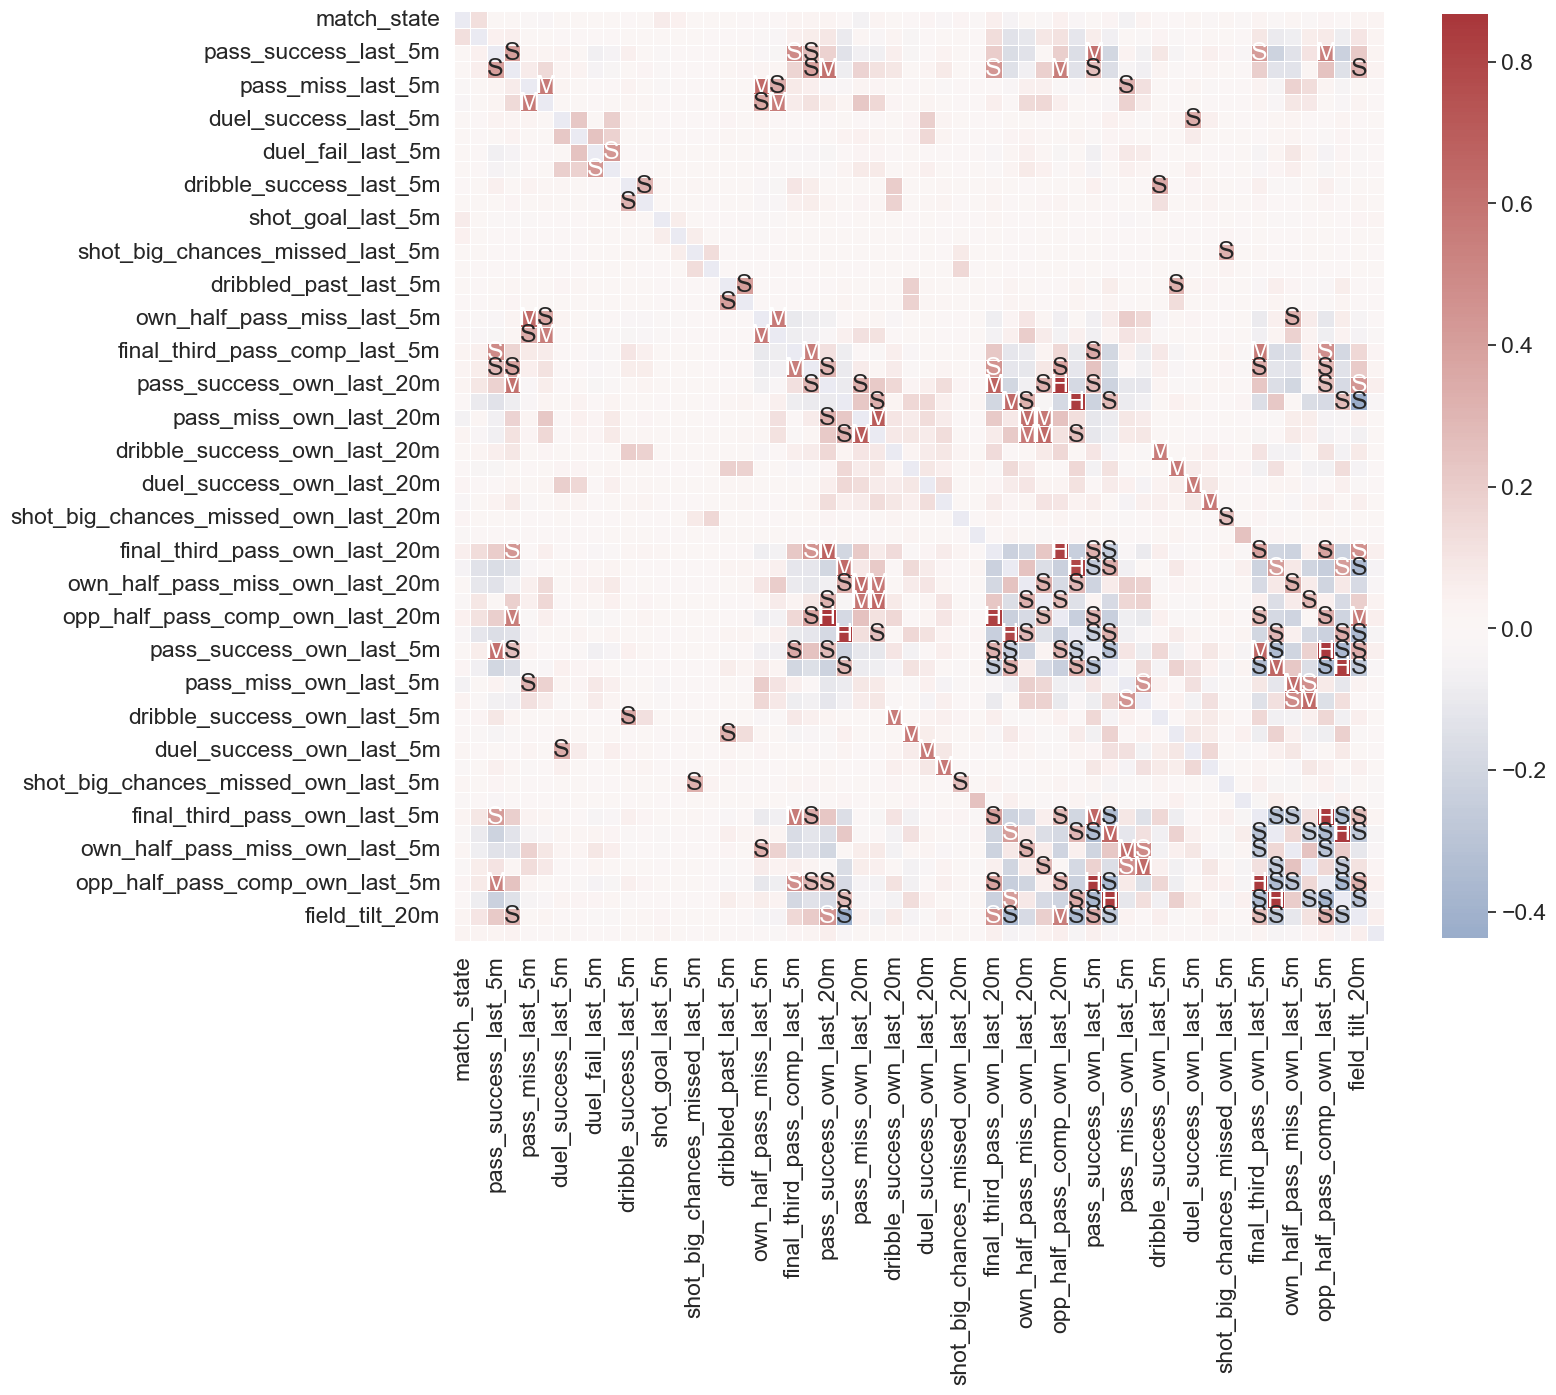

In [116]:
#Feature correlation

# Computes feature correlation
df_corr = model_scoring.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "S", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8},);

<h2>Own/opp team vars

In [117]:
target="scoring_in_10"
features=model_scoring.drop([target],axis=1).columns

In [118]:
 X_train, X_test, y_train, y_test = train_test_split(model_scoring[features], model_scoring[target], test_size=0.33, random_state=42)

In [119]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [127]:
model=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
evaluate_model(model_scoring,model)

KeyboardInterrupt: 

In [ ]:
model=RandomForestClassifier()
evaluate_model(model_scoring,model)

In [122]:
model=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
evaluate_model(model_scoring,model)#new

,Auc,F1,Prec,Recall,Roc
0,0.540,0.252,0.166,0.535,0.538


In [123]:
model=xgboost.XGBRFClassifier()
evaluate_model(model_scoring,model)#new

,Auc,F1,Prec,Recall,Roc
0,0.854,0.000,0.219,0.000,0.500


<h2>Home/away old version

In [80]:
target="scoring_in_10"
features=model_scoring_30.drop([target],axis=1).columns

In [81]:
model=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
evaluate_model(model_scoring_30,model)#new

,Auc,F1,Prec,Recall,Roc
0,0.854,0.001,0.325,0.000,0.500


In [82]:
model=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
evaluate_model(model_scoring_30,model)#new

,Auc,F1,Prec,Recall,Roc
0,0.378,0.250,0.152,0.712,0.516


In [53]:
model=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
evaluate_model(model_scoring_30,model)

,Auc,F1,Prec,Recall,Roc
0,0.748,0.159,0.145,0.175,0.507


In [54]:
model=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
evaluate_model(model_scoring_30,model)

,Auc,F1,Prec,Recall,Roc
0,0.570,0.221,0.148,0.451,0.520


In [59]:
model_scoring_30.scoring_in_10.value_counts()

0    1048643
1     178635
Name: scoring_in_10, dtype: int64

In [61]:
1-178635/1048643

0.8296512731215485

In [51]:
 X_train, X_test, y_train, y_test = train_test_split(model_scoring_30[features], model_scoring_30[target], test_size=0.33, random_state=42)

In [52]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [93]:
model_LR=RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

In [94]:
model_LR.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.5853314768465921,
                                     1: 3.429751238800741})

In [95]:
preds=model_LR.predict(X_test)

In [96]:
conf=confusion_matrix(y_test,preds)

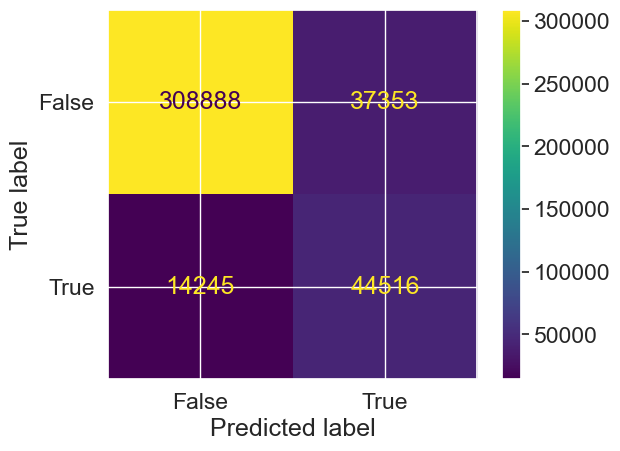

In [97]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show()

In [100]:
model_LR=xgboost.XGBRFClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
model_LR.fit(X_train,y_train)
preds=model_LR.predict(X_test)
conf=confusion_matrix(y_test,preds)

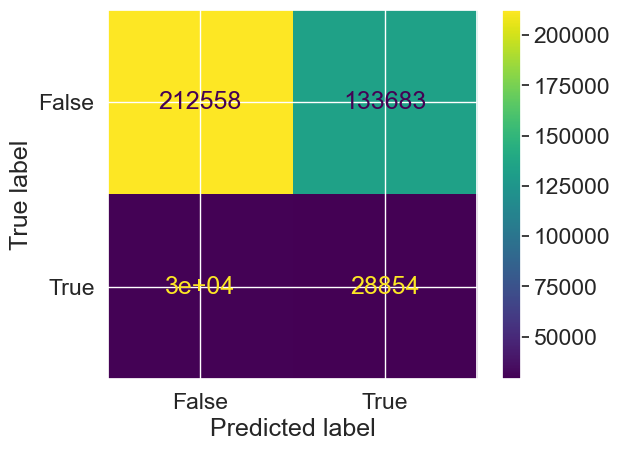

In [101]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show()

<h2>Eredmenyek: </h2>
LogisticR: 0 True --> Kuka

   

RF: AUC:0.762 PREC: 0.14 REC: 0.127

RF(home+away, 30+15) AUC: 0.748 PREC:0.145

In [23]:
req_types=["Pass","Shot","Dribble","Duel"]

In [46]:
new_cols=["minute","event_success","next_event"]
minutes=30
for column in variables:
    df=last_X_summary(df,column,minutes)
    new_cols.append(column+'_last_'+str(minutes)+'m')
df["event_success"]=np.where((df["pass_success"]==1)|(df["duel_success"]==1)|(df["dribble_success"]==1)|(df["shot_goal"]==1),1,0)
pre_model=df[df["type"].isin(req_types)]
pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)
model45_df=pre_model[pre_model["minute"]>20][new_cols].fillna(0)

C:\Users\judod\AppData\Local\Temp\ipykernel_17888\1932480728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)


In [25]:
model_cols=["minute","event_success","next_event"]
minutes=10
for column in variables:
    df=last_X_summary(df,column,minutes)
    model_cols.append(column+'_last_'+str(minutes)+'m')
df["event_success"]=np.where((df["pass_success"]==1)|(df["duel_success"]==1)|(df["dribble_success"]==1)|(df["shot_goal"]==1),1,0)
pre_model=df[df["type"].isin(req_types)]
pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)
model30_df=pre_model[pre_model["minute"]>20][model_cols].fillna(0)

C:\Users\judod\AppData\Local\Temp\ipykernel_17888\2154801824.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)


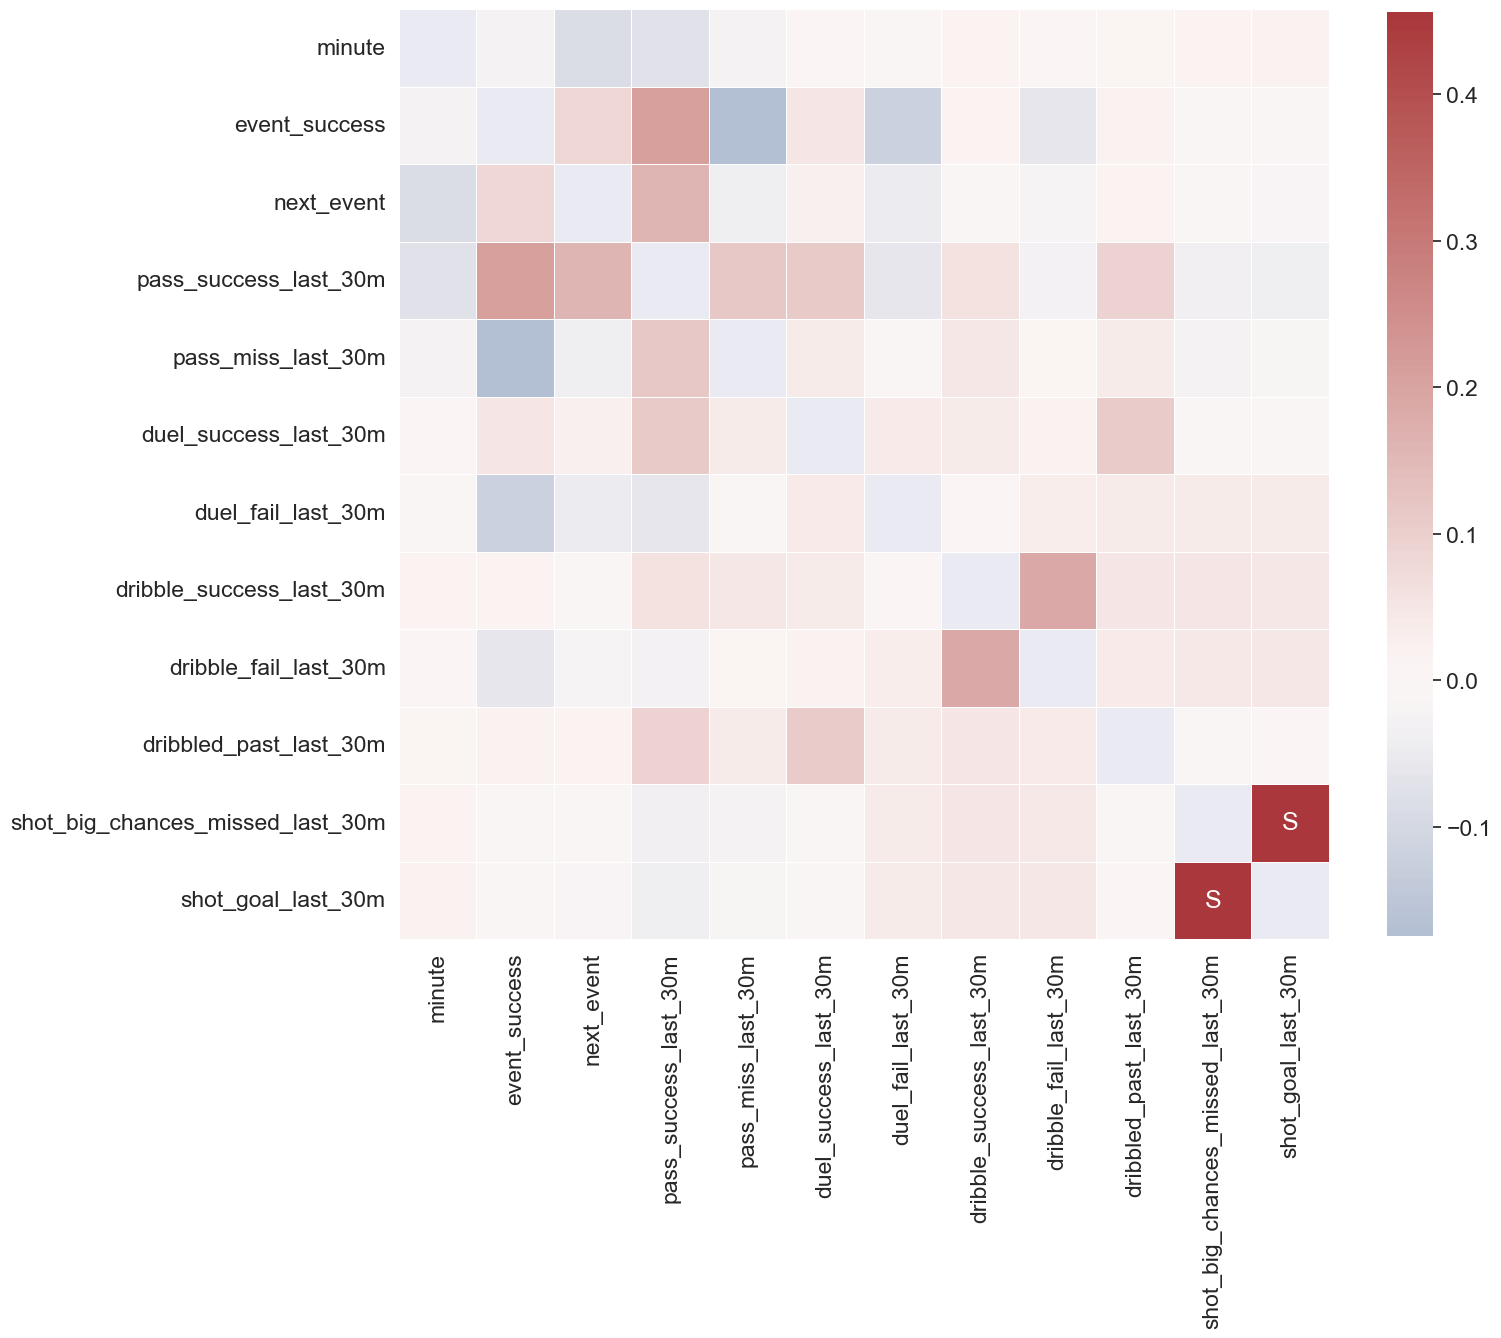

In [47]:
#Feature correlation

# Computes feature correlation
df_corr = model45_df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "S", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8},);

In [29]:
target="next_event"

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression

In [32]:
def training(train, test, model, encoder, scaler=None, imputer='zero'):
    x_train = train[features]
    y_train = train[target]
    x_test = test[features]
    y_test = test[target]

    pipe = Pipeline(steps=[
        ("encoder", encoder),
        ("scaler", scaler),
        ("Model", model)
    ])
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)
    auc = accuracy_score(y_test, preds)
    f1=f1_score(y_test,preds)
    prec=precision_score(y_test,preds)
    rec=recall_score(y_test,preds)
    
    metric_dict = {'Auc':auc, 'F1':f1,'Prec':prec,'Recall':rec}
    metric_dict=pd.DataFrame([metric_dict])
    
    return(metric_dict)

In [33]:
def evaluate_model(df, model, encoder=None, scaler=None):
    rand_state = 42
    y = df[target]
    X = df[features]
    df = df.fillna(0)
    skf = KFold(n_splits=5)
    metric_df = pd.DataFrame(columns=['Auc', 'F1','Prec','Recall'])

    fold_no = 1
    for train_index,test_index in skf.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        metric_dict = training(train, test, model, encoder, scaler)
        metric_df = pd.concat([metric_df, metric_dict], ignore_index=True)
        fold_no += 1

    means = metric_df.mean()
    metric_df = pd.DataFrame(columns = means.index)
    metric_df.loc[len(metric_df)] = means.values
    return(metric_df)

In [39]:
features=model45_df.drop(["next_event","event_success"],axis=1).columns

In [40]:
model=DecisionTreeClassifier()
evaluate_model(model45_df,model)

,Auc,F1,Prec,Recall
0,0.572,0.674,0.700,0.650


In [41]:
model=LogisticRegression(max_iter=1000)
evaluate_model(model45_df,model)

,Auc,F1,Prec,Recall
0,0.686,0.810,0.689,0.983


In [44]:
features=model30_df.drop(["next_event","event_success"],axis=1).columns

In [35]:
model=LogisticRegression(max_iter=1000)
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.683,0.810,0.684,0.994


In [45]:
model=GaussianNB()
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.669,0.793,0.690,0.932


In [37]:
model=KNeighborsClassifier()
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.639,0.756,0.701,0.820


In [180]:
model45_df.next_event.value_counts()

1.000    219771
0.000    102859
Name: next_event, dtype: int64

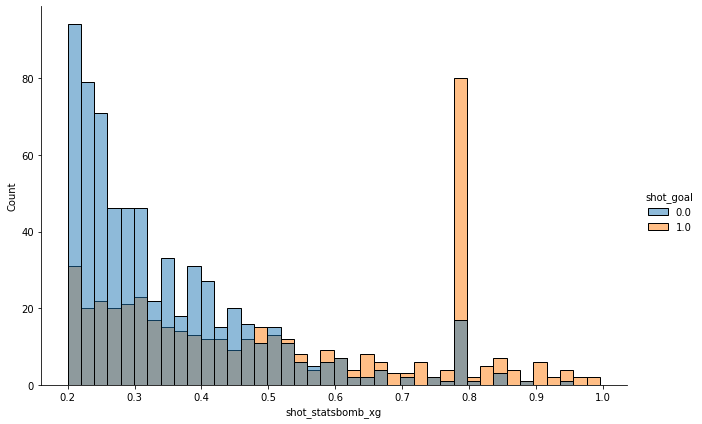

In [90]:
sns.displot(data=df[(df["type"]=='Shot')&(df["shot_statsbomb_xg"]>0.2)],x='shot_statsbomb_xg',hue='shot_goal',height=6,aspect=1.5,bins=40)

In [85]:
df.type.value_counts()

Pass                 368619
Ball Receipt*        340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Substitution           2109
Half Start             1520
Half End               1520
Injury Stoppage        1032
Starting XI             760
Tactical Shift          625
50/50                   559
Shield                  503
Referee Ball-Drop       272
Bad Behaviour           193
Error                   178
Player Off              145
Player On               144
Offside                 109
Own Goal Against         38
Own Goal For             38
Name: type, dtype: int64